## Imports

In [1]:
import nltk
import pandas as pd
import re
import string
import seaborn as sns
import numpy as np
import dill

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold, GridSearchCV

from matplotlib import pyplot as plt

In [3]:
from sklearn import set_config
set_config(print_changed_only = False)

%matplotlib inline

## Loading Data and EDA

In [4]:
train_df = pd.read_csv('Datasets/train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test_df = pd.read_csv('Datasets/test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
train_df.shape

(7613, 5)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

## Feature Engineering

### Hashtag Count

In [9]:
hashtag = r"#[a-zA-Z]\w+"
train_df['hashtag_count'] = train_df['text'].apply(lambda txt: len(re.findall(hashtag, txt))).astype('int16')
train_df.sample(5)

,id,keyword,location,text,target,hashtag_count
5983,8543,screams,Griffin :3,@DaneMillar1 *screams 666*,0,0
6373,9107,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1,1
4654,6617,inundated,NaN,@BCFCTicketLady @Mr_Aamir_Javaid Can see you a...,0,1
1594,2301,cliff%20fall,"Madrid, Comunidad de Madrid",ESN : Cilla Black died of stroke after fall i...,0,0
3371,4829,evacuation,"Bend, Oregon",Evacuation Advisory for Swayback Ridge Area..v...,1,2


In [10]:
test_df['hashtag_count'] = test_df['text'].apply(lambda txt: len(re.findall(hashtag, txt))).astype('int16')
test_df.sample(5)

,id,keyword,location,text,hashtag_count
2058,6906,mass%20murderer,NaN,@AParra210 So you are stereotyping the people....,0
395,1281,bloody,Waiheke Island,The whole of New Zealand is shouting 'Bloody M...,1
1155,3808,detonate,NaN,Apollo Brown - Detonate (ft. M.O.P.) [Single] ...,0
1884,6352,hostages,france,#hot C-130 specially modified to land in a st...,3
1042,3424,derail,Road to the Billionaires Club,@QueenBrittani_ GM! I pray any attack of the e...,0


In [11]:
train_df['hashtag_count'].describe()

count    7613.000000
mean        0.428609
std         1.073889
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        13.000000
Name: hashtag_count, dtype: float64

<AxesSubplot:xlabel='hashtag_count', ylabel='count'>

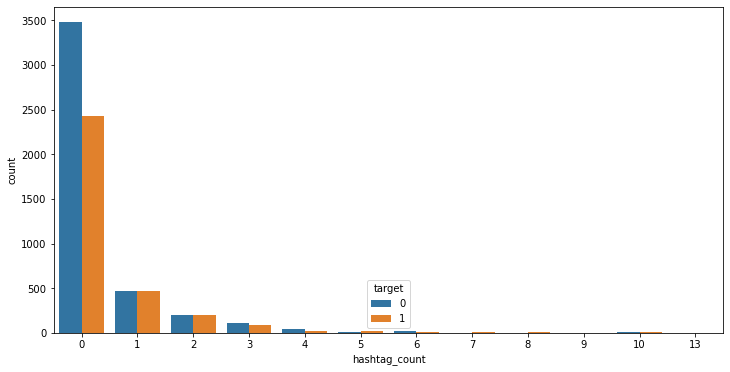

In [12]:
plt.figure(figsize=(12,6))
sns.countplot(x= 'hashtag_count', hue='target', data = train_df)

### Keywords

In [13]:
train_df['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [14]:
train_df['keyword'].replace(to_replace = '%20', value = ' ', inplace = True, regex = True)
test_df['keyword'].replace(to_replace = '%20', value = ' ', inplace = True, regex = True)

In [15]:
train_df['keyword'].fillna(value = 'NaN', inplace = True)
test_df['keyword'].fillna(value = 'NaN', inplace = True)

print('Null value count for keywords in training dataset: ', train_df['keyword'].isnull().sum())
print('Null value count for keywords in testing dataset: ', test_df['keyword'].isnull().sum())

Null value count for keywords in training dataset:  0
Null value count for keywords in testing dataset:  0


In [16]:
train_df['keyword'].unique()

array(['NaN', 'ablaze', 'accident', 'aftershock', 'airplane accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown up', 'body bag', 'body bagging', 'body bags',
       'bomb', 'bombed', 'bombing', 'bridge collapse',
       'buildings burning', 'buildings on fire', 'burned', 'burning',
       'burning buildings', 'bush fires', 'casualties', 'casualty',
       'catastrophe', 'catastrophic', 'chemical emergency', 'cliff fall',
       'collapse', 'collapsed', 'collide', 'collided', 'collision',
       'crash', 'crashed', 'crush', 'crushed', 'curfew', 'cyclone',
       'damage', 'danger', 'dead', 'death', 'deaths', 'debris', 'deluge',
       'deluged', 'demolish', 'demolished', 'demolition', 'derail',
       'derailed', 'derailment', 'des

In [17]:
kw_oe = OrdinalEncoder(dtype='int16')
kw_oe.fit(train_df[['keyword']])

OrdinalEncoder(categories='auto', dtype='int16')

In [18]:
train_df['keyword'] = kw_oe.transform(train_df[['keyword']])
train_df.sample(5)

,id,keyword,location,text,target,hashtag_count
4797,6824,139,Kenya,k_matako_bot: Breaking news! Unconfirmed! I ju...,0,0
1314,1898,38,NaN,If you're bored with life if you don't get up ...,0,0
7328,10488,215,NaN,Route Complex AM Fire Update (Route Complex Wi...,1,1
2616,3754,76,"Georgia, USA",@cinla1964 @windowgatribble The Contrasts of F...,0,0
6760,9686,198,"Dindigul,TamilNadu.",@kunalkapoor Photo of the Day: Storm\nChaser\n...,1,2


In [19]:
test_df.loc[~test_df['keyword'].isin(kw_oe.categories_[0]), "keyword"] = 'NaN'
test_df['keyword'] = kw_oe.transform(test_df[['keyword']])
test_df.sample(5)

,id,keyword,location,text,hashtag_count
517,1695,34,NaN,Two giant cranes holding a bridge collapse int...,0
1285,4226,85,NaN,@oilersjaysfan how's the rain have you drowned...,0
2849,9443,193,FLA,@BBCNewsAsia State sponsored terrorism.,0
2764,9190,187,NaN,IS claims suicide bombing against Saudi police...,1
1047,3441,69,NaN,HillaryÛªs Bimbo Eruptions and Questionable F...,0


### Length of text

In [20]:
train_df['text_len'] = train_df['text'].apply(lambda x: len(x) - x.count(" ")).astype('int16')
train_df.sample(5)

,id,keyword,location,text,target,hashtag_count,text_len
4184,5943,121,Arizona,Get that hazard pay,0,0,16
3717,5285,107,"Thibodaux, LA",my worst fear. https://t.co/iH8UDz8mq3,0,0,35
2106,3025,61,NaN,https://t.co/eCMUjkKqX1 @ArianaGrande @ScreamQ...,0,0,66
2494,3583,72,"Michigan, USA",Psalm34:22 The Lord redeemeth the soul of his ...,0,0,90
1784,2560,52,NaN,@SterlingKnight Who had a car crashsterling!W...,0,0,90


In [21]:
test_df['text_len'] = test_df['text'].apply(lambda x: len(x) - x.count(" ")).astype('int16')
test_df.sample(5)

,id,keyword,location,text,hashtag_count,text_len
1980,6677,136,NaN,I liked a @YouTube video from @seeiey http://t...,0,69
1943,6557,133,www.dorsavi.com,Supermarket chains recording worst #injury rat...,2,92
1008,3321,67,"Paterson, New Jersey",@Ramdog1980 Israeli soldiers demolished a resi...,0,117
740,2405,49,NaN,?Maybe someday we'll find the place where our ...,0,63
967,3213,65,NaN,Businesses cre deluged with invoices. Make you...,0,108


In [22]:
train_df['text_len'].describe()

count    7613.000000
mean       87.108499
std        29.151660
min         6.000000
25%        67.000000
50%        92.000000
75%       114.000000
max       138.000000
Name: text_len, dtype: float64

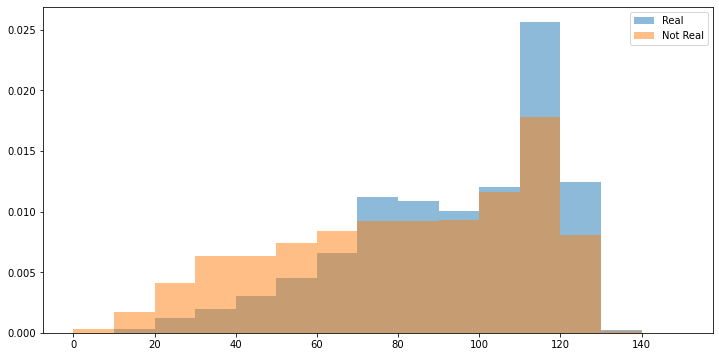

In [23]:
bins = np.linspace(0, 150, 16)

plt.figure(figsize = (12, 6))
plt.hist(train_df[train_df['target'] == 1]['text_len'], bins, alpha = 0.5, density = True, label = 'Real')
plt.hist(train_df[train_df['target'] == 0]['text_len'], bins, alpha = 0.5, density = True, label = 'Not Real')
plt.legend()
plt.show()

### Word count

In [24]:
wn = nltk.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')

In [25]:
def tokenize_text(text):
    text = text.lower()
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = re.split('[^a-z]+', text)
    return tokens

def clean_text(tokens):
    text = [wn.lemmatize(word) for word in tokens if not (word in stopwords or str.isspace(word) or len(word)==0)]
    return text 

In [26]:
train_df['text'] = train_df['text'].apply(lambda txt: tokenize_text(txt))
train_df['word_count'] = train_df['text'].apply(lambda tokens: len(tokens)).astype('int16')
train_df.sample(5)

,id,keyword,location,text,target,hashtag_count,text_len,word_count
6984,10016,205,Detroit,"[crazy, mom, threw, teen, daughter, a, nude, t...",0,0,119,20
7184,10294,211,New York 2099,"[dwarfonjetpack, i, guess, i, can, say, you, a...",0,0,105,26
2761,3967,80,"Washington, DC","[, years, after, atomic, bombs, japan, still, ...",1,0,120,22
2648,3802,77,Milton/Tallahassee,"[apollo, brown, ft, mop, detonate, httptcoomfg...",1,0,51,8
701,1009,20,NaN,"[acousticmaloley, no, he, was, blazing, it]",0,0,32,6


In [27]:
test_df['text'] = test_df['text'].apply(lambda txt: tokenize_text(txt))
test_df['word_count'] = test_df['text'].apply(lambda tokens: len(tokens)).astype('int16')
test_df.sample(5)

,id,keyword,location,text,hashtag_count,text_len,word_count
391,1265,25,NaN,"[, bloods, penny, post, philly, octagonal, cds...",0,112,14
3148,10453,214,New york,"[hey, macys, my, moms, house, burned, down, in...",0,116,26
1338,4418,89,Under the rain...,"[so, that, itll, electrocute, somebodys, ass, ...",0,74,12
1977,6671,136,"New Delhi, Delhi","[preetichopra, chinmaykrvd, many, predicted, l...",0,111,20
83,286,5,World,"[, held, with, heroin, in, ambulance, httptcod...",0,70,10


In [28]:
train_df['word_count'].describe()

count    7613.000000
mean       15.382372
std         5.660104
min         1.000000
25%        11.000000
50%        16.000000
75%        20.000000
max        31.000000
Name: word_count, dtype: float64

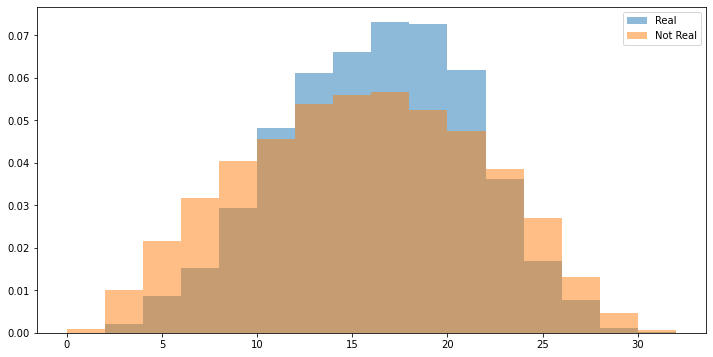

In [29]:
bins = np.linspace(0, 32, 17)

plt.figure(figsize = (12, 6))
plt.hist(train_df[train_df['target'] == 1]['word_count'], bins, alpha = 0.5, density = True, label = 'Real')
plt.hist(train_df[train_df['target'] == 0]['word_count'], bins, alpha = 0.5, density = True, label = 'Not Real')
plt.legend()
plt.show()

### TF-IDF

In [30]:
tfidf_vect = TfidfVectorizer(analyzer= clean_text, dtype = 'float32')
tfidf_vect_fit = tfidf_vect.fit(train_df['text'])

In [31]:
tfidf_vect_columns = ['tf_' + colname for colname in tfidf_vect.get_feature_names()]
tfidf_vect_columns[::1000]

['tf_aa',
 'tf_autism',
 'tf_btwn',
 'tf_compensate',
 'tf_diary',
 'tf_escape',
 'tf_funemes',
 'tf_hew',
 'tf_httptcodknlznom',
 'tf_httptcomjfdcrjs',
 'tf_httptcovpqtgeqlma',
 'tf_investigative',
 'tf_kvzbn',
 'tf_mayoroflondon',
 'tf_nft',
 'tf_pbc',
 'tf_quarter',
 'tf_rymfjcux',
 'tf_soonersportstv',
 'tf_thankfully',
 'tf_uphill',
 'tf_worstever']

In [32]:
train_tf_df = pd.DataFrame(tfidf_vect_fit.transform(train_df['text']).toarray(), columns = tfidf_vect_columns)
train_tf_df.sample(5)

,tf_aa,tf_aaaa,tf_aaaaaaallll,tf_aaaaaand,tf_aaarrrgghhh,tf_aaceorg,tf_aag,tf_aal,tf_aampb,tf_aampw,...,tf_zykct,tf_zynp,tf_zz,tf_zzbha,tf_zzcupnz,tf_zzk,tf_zznbvfuvo,tf_zzr,tf_zzuz,tf_zzzz
3651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
test_tf_df = pd.DataFrame(tfidf_vect_fit.transform(test_df['text']).toarray(), columns = tfidf_vect_columns)
test_tf_df.sample(5)

,tf_aa,tf_aaaa,tf_aaaaaaallll,tf_aaaaaand,tf_aaarrrgghhh,tf_aaceorg,tf_aag,tf_aal,tf_aampb,tf_aampw,...,tf_zykct,tf_zynp,tf_zz,tf_zzbha,tf_zzcupnz,tf_zzk,tf_zznbvfuvo,tf_zzr,tf_zzuz,tf_zzzz
2006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Preparing training data

In [34]:
X_features = pd.concat([train_df[['keyword', 'hashtag_count', 'text_len', 'word_count']], train_tf_df], axis = 1)
X_features.shape

(7613, 21749)

In [35]:
Y_label = train_df['target']
Y_label.shape

(7613,)

In [36]:
X_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Columns: 21749 entries, keyword to tf_zzzz
dtypes: float32(21745), int16(4)
memory usage: 631.6 MB


## Random Forest Classifier

In [37]:
rf = RandomForestClassifier(random_state = 7)
rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

### Hyperparameter tuning using GridSearchCV

In [38]:
%%time
param = {'n_estimators': [100, 150, 200, 250],
        'max_depth': [50, 100, None],
        'class_weight': ['balanced_subsample', None],
        'max_samples': [0.5, 0.75, None]}

k_fold = KFold(n_splits = 5)

gs = GridSearchCV(rf, param, cv = k_fold, n_jobs = -1)
gs_fit = gs.fit(X_features, Y_label)

Wall time: 49min 36s


In [39]:
pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending = False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_max_samples,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
21,85.912186,4.385638,0.761969,0.136654,balanced_subsample,100,None,150,"{'class_weight': 'balanced_subsample', 'max_de...",0.764938,0.737360,0.697308,0.702365,0.772011,0.734796,0.030845,1
20,59.254110,3.065963,0.727561,0.118304,balanced_subsample,100,None,100,"{'class_weight': 'balanced_subsample', 'max_de...",0.760341,0.738017,0.698621,0.705650,0.769382,0.734402,0.028342,2
22,108.689096,5.476783,0.762964,0.075388,balanced_subsample,100,None,200,"{'class_weight': 'balanced_subsample', 'max_de...",0.759685,0.739330,0.695995,0.697109,0.772011,0.732826,0.031405,3
23,138.702144,6.706474,1.013204,0.148993,balanced_subsample,100,None,250,"{'class_weight': 'balanced_subsample', 'max_de...",0.760998,0.740643,0.697308,0.699737,0.760184,0.731774,0.028122,4
16,49.280482,1.700396,0.758576,0.204913,balanced_subsample,100,0.75,100,"{'class_weight': 'balanced_subsample', 'max_de...",0.751806,0.741957,0.689429,0.706965,0.760841,0.730199,0.027372,5


In [40]:
gs_fit.best_params_

{'class_weight': 'balanced_subsample',
 'max_depth': 100,
 'max_samples': None,
 'n_estimators': 150}

In [41]:
X_test_features = pd.concat([test_df[['keyword', 'hashtag_count', 'text_len', 'word_count']], test_tf_df], axis = 1)
X_test_features.shape

(3263, 21749)

In [42]:
y_hat = gs_fit.predict(X_test_features)
y_hat.shape

(3263,)

In [43]:
test_df = pd.concat([test_df, pd.DataFrame(y_hat, columns=['target'])], axis = 1)
test_df.head()

,id,keyword,location,text,hashtag_count,text_len,word_count,target
0,0,0,NaN,"[just, happened, a, terrible, car, crash]",0,29,6,0
1,2,0,NaN,"[heard, about, earthquake, is, different, citi...",1,56,9,1
2,3,0,NaN,"[there, is, a, forest, fire, at, spot, pond, g...",0,78,19,1
3,9,0,NaN,"[apocalypse, lighting, spokane, wildfires]",2,37,4,0
4,11,0,NaN,"[typhoon, soudelor, kills, in, china, and, tai...",0,38,7,1


In [44]:
submission_df = test_df[['id', 'target']]
submission_df.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


In [45]:
submission_df.to_csv('disaster_tweet_nlp_mayur.csv', index=False)

## Model Pickling

### Keyword Ordinal Encoder

In [46]:
with open('Models/kw_oe.pkl', 'wb') as file:
    dill.dump(kw_oe, file)

### TF-IDF Vectorizer

In [47]:
with open('Models/tfidf.pkl', 'wb') as file:
    dill.dump(tfidf_vect_fit, file)

### Random Forest Model

In [48]:
with open('Models/rf.pkl', 'wb') as file:
    dill.dump(gs_fit.best_estimator_, file)